# Problem :

**Classify pnemonia/ no-pnemonia from given chest x-ray images.There can be a seperate classifier for Images with pnemonia to sub-divide it into Viral-pnemonia and Bacterial-pnemonia, but I won't do that here because of heavy class imbalance.**

# Resources:
* [ https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays ]
* [ https://www.kaggle.com/rahulvv/image-classification-using-efficientnetb7 ]

# Imports

In [1]:

import os,gc
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split as tts 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import load_img,img_to_array,smart_resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers 
from tensorflow.keras import backend as K
from tensorflow.io import decode_image
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model

#supress warnings
import warnings 
warnings.filterwarnings('ignore')

# Loading data 

In [2]:
metadata=pd.read_csv('../input/coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv')
data=pd.read_csv('../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')

#train and test dir.
test_dir='../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
train_dir='../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

metadata

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


I will make a classifier that would classify between three classes,i.e normal,viral pnemonia and bacterial pnuemonia.

In [3]:
data.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


COVID-19


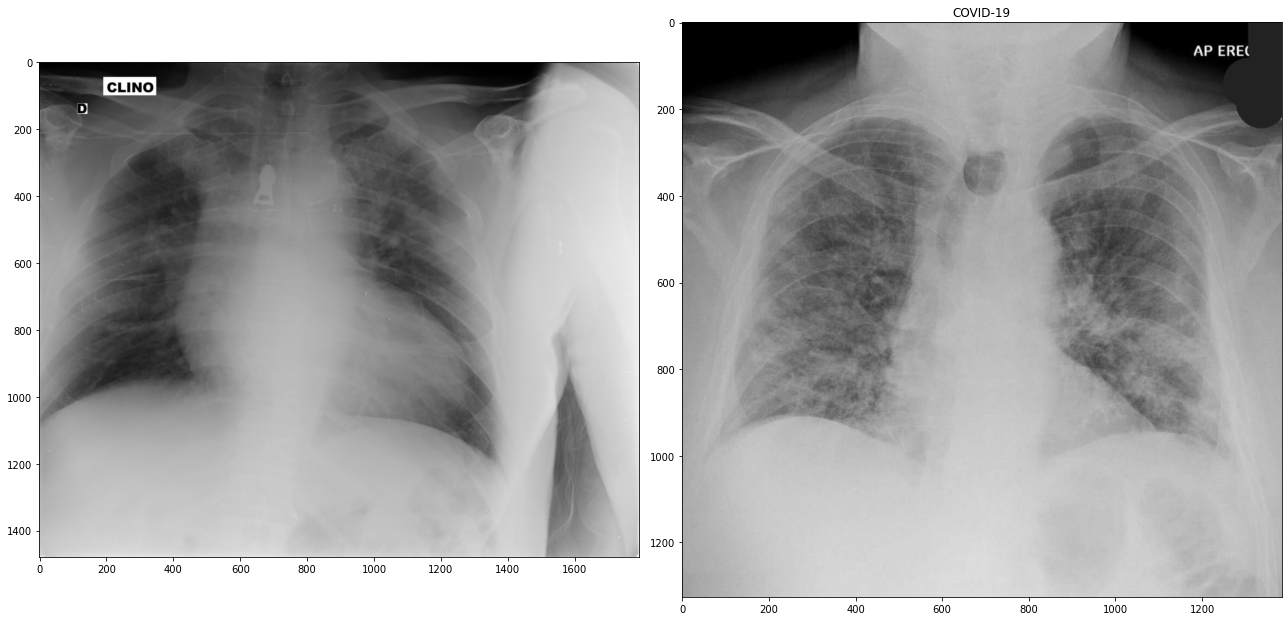

In [4]:
def show_sample_image(df,label,train_dir=train_dir):
    fig,ax=plt.subplots(1,2,figsize=(18,9))
    img_ids=df[df['Label_2_Virus_category'] == label].sample(2)
    
    print(f'{label.upper()}')
    #image 1
    img1=os.path.join(train_dir,img_ids['X_ray_image_name'].iloc[0])
    img1=load_img(img1)
    ax[0].imshow(img1)
    
    #image 2
    img2=os.path.join(train_dir,img_ids['X_ray_image_name'].iloc[1])
    img2=load_img(img2)
    ax[1].imshow(img2)
    
    plt.tight_layout()
    plt.title(f'{label}')
    plt.show()
    
show_sample_image(data,label='COVID-19')

COVID-19


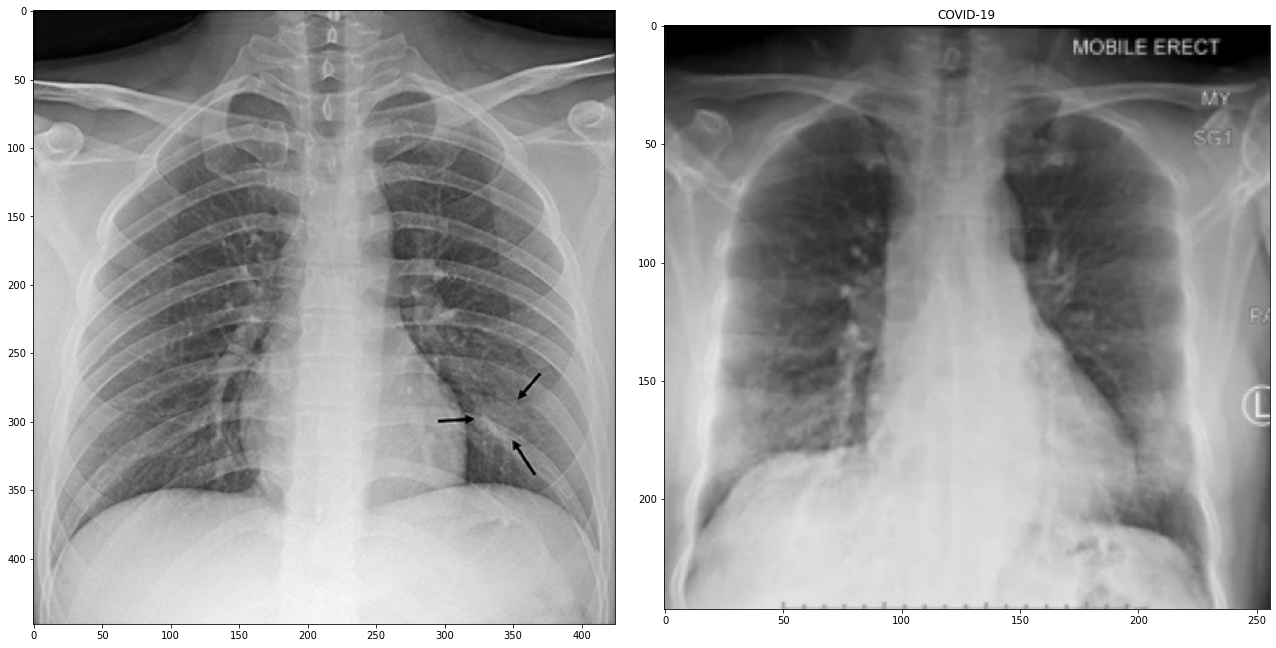

In [5]:
show_sample_image(data,label='COVID-19')

ARDS


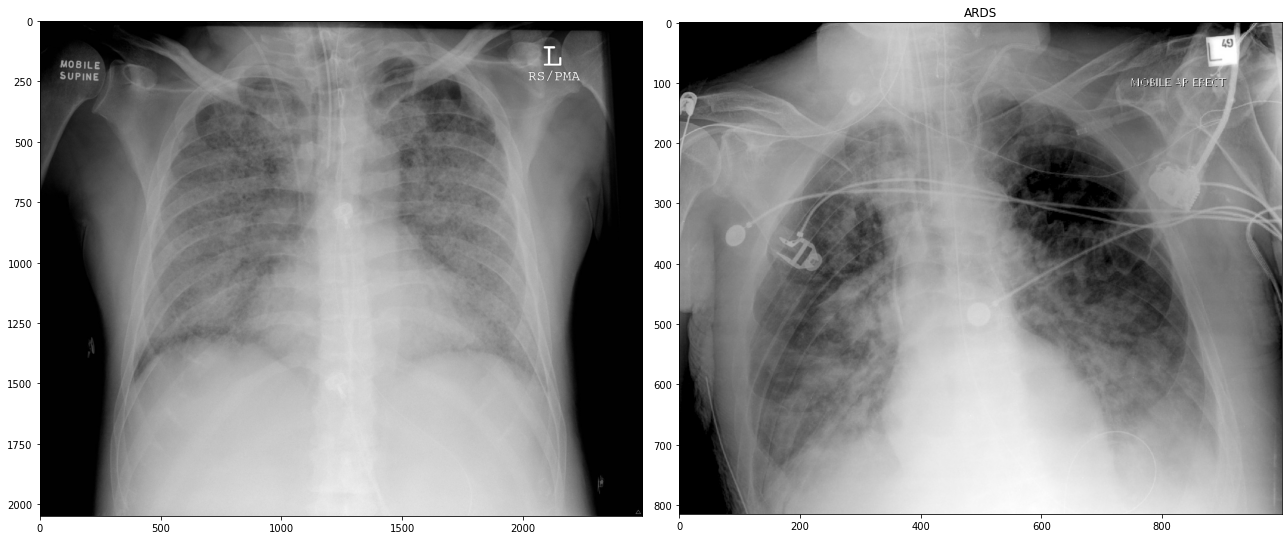

In [6]:
show_sample_image(data,label='ARDS')

SARS


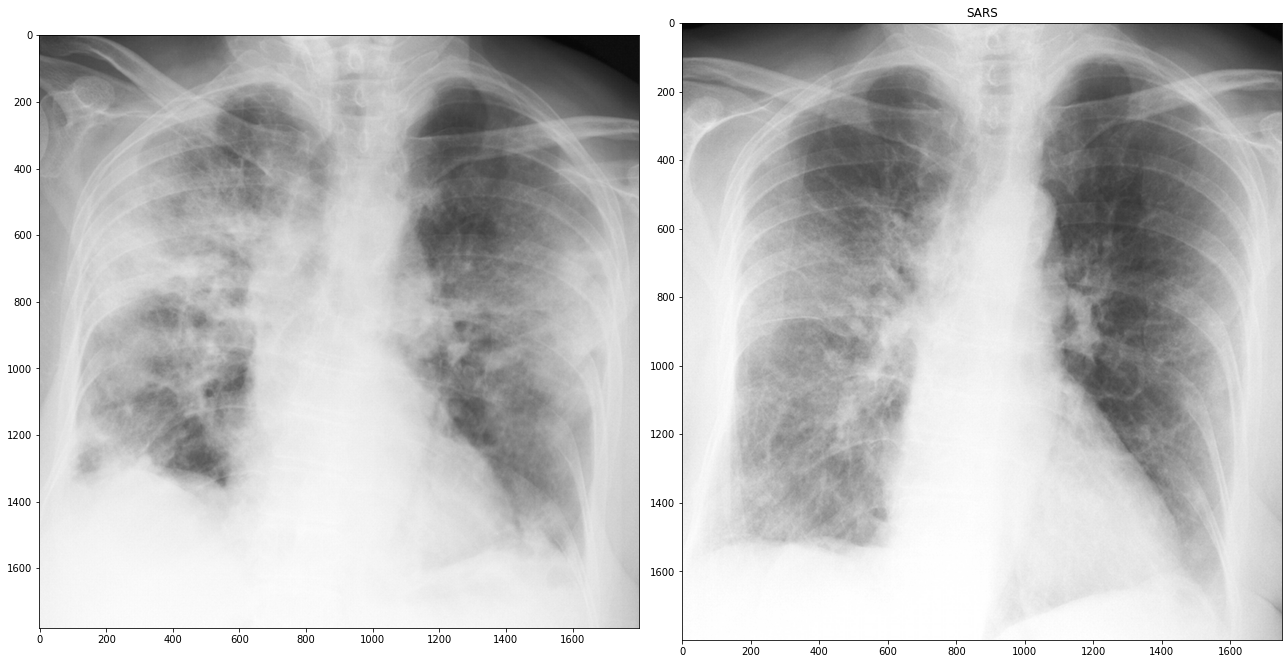

In [7]:
show_sample_image(data,label='SARS')

Text(0.5, 1.0, 'Class balance')

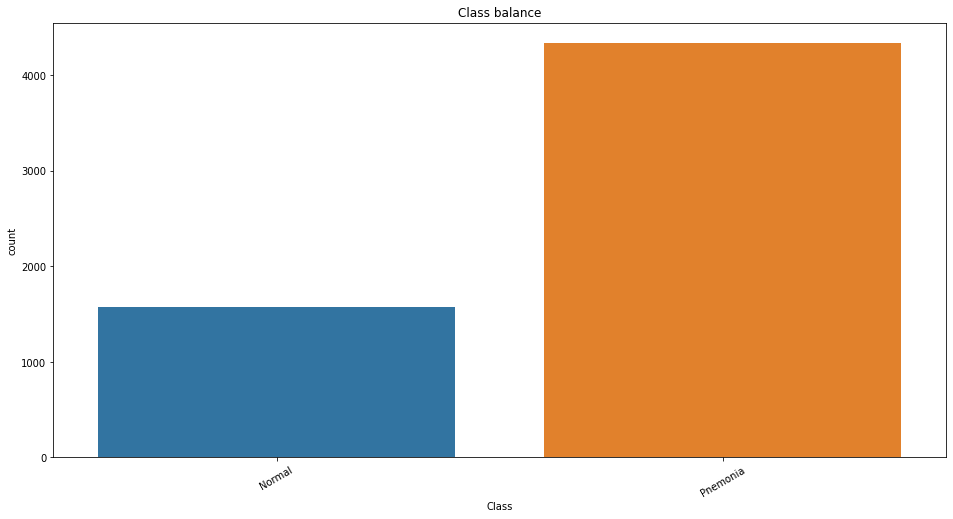

In [8]:
# type

plt.figure(figsize=(16,8))
sns.countplot(data['Label'])
plt.xlabel('Class')
plt.xticks(rotation=30)
plt.title('Class balance')

**Setting variables and random seed**

In [9]:
img_size=(256,256)
batch_size=64

#setting seed 
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
set_seed(7)

**Loading Images with Image Data generator**

In [10]:
#train_test_split
train_df,valid_df=tts(data,test_size=0.1,random_state=7,stratify=data['Label'])
    
def load_data(df):
    #Image data generator :
    
#     train_set
    train_gen=ImageDataGenerator(
    width_shift_range=(0.1,0.2),
    height_shift_range=(0.1,0.2),
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255)

#     val_set
    val_gen=ImageDataGenerator(rescale=1./255)
    
    #load_data
    train=train_gen.flow_from_dataframe(dataframe=train_df,
                                         directory=train_dir,
                                         x_col='X_ray_image_name' ,
                                         y_col='Label'  ,
                                         target_size=img_size,
                                         batch_size=batch_size,
                                         class_mode='binary',
                                         shuffle=True,
                                         seed=7)
    
    val=val_gen.flow_from_dataframe(dataframe=valid_df,
                                         directory=train_dir,
                                         x_col='X_ray_image_name' ,
                                         y_col='Label'  ,
                                         target_size=img_size,
                                         batch_size=batch_size,
                                         class_mode='binary',
                                         shuffle=True,
                                         seed=7)
    
    return train,val

train,val=load_data(data)

Found 4761 validated image filenames belonging to 2 classes.
Found 525 validated image filenames belonging to 2 classes.


**Because there is heavy imbalance in target,I will use class weights argument in model training**

In [11]:
def class_weights(df,target_column):
    '''Calculates target class weights to be used in case of imbalanced data. '''
    
    from sklearn.utils.class_weight import compute_class_weight
    
    return compute_class_weight('balanced',df[target_column].unique(),df[target_column])


#compute class weights:
weights=class_weights(train_df,'Label')
weights={0:weights[0],1:weights[1]}
print(weights)

{0: 0.6817482696744425, 1: 1.8755289139633287}


# Building Models

In [12]:
# Using efficientnet as base layer:
base=EfficientNetB7(weights='imagenet',include_top=False,)
set_trainable=False
    
#freezing all layers before 'block7c_project_conv'

for layer in base.layers:
    if layer.name == 'block7c_project_conv':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False


def effnet(dense,dropout):  
    inp=layers.Input(shape=(256,256,3))
    #base layer
    x=base(inp)
    x=layers.MaxPooling2D()(x)
    x=layers.Dropout(0.3)(x)
    
    #flatten output:
    x=layers.Flatten()(x)
        
    for i in range(len(dense)):
        x=layers.BatchNormalization()(x)
        x=layers.Dense(dense[i],activation='relu')(x)
        x=layers.Dropout(rate=drop[i])(x)
    
    x=layers.BatchNormalization()(x)
    output=layers.Dense(1,activation='softmax')(x)
    
    #model
    model=Model(inputs=inp,outputs=output)
    
    return model


# plotting history:
def plot_history(history):
    his=pd.DataFrame(history.history)
    plt.style.use('Solarize_Light2')
    plt.subplots(1,2,figsize=(16,8))
    
    #loss:
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['loss'],color='g',label='training')
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.legend()
    plt.title('Loss')
    
    #accuracy and AUC:
    plt.subplot(1,2,2)
#     plt.plot(range(len(his)),his['auc'],color='g',label='training')
#     plt.plot(range(len(his)),his['val_auc'],color='r',label='validation')
    
    plt.plot(range(len(his)),his['accuracy'],color='steelblue',label='training')
    plt.plot(range(len(his)),his['val_accuracy'],color='maroon',label='validation')
    
    
    plt.legend()
    plt.title('Accuracy')
    

    plt.show()                

258080768/258076736 [==============================] - 2s 0us/step


In [13]:
#model2 EfficientNet B0 base:
dense=[64]                # dense layers 
drop=[0.5]                #dropout probabilities
epochs2=30

#model2
model2=effnet(dense,drop)

#compiling model:

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#reduce learning rate 
reduce_lr=ReduceLROnPlateau(patience=1,monitor='val_accuracy',
                            factor=0.5,min_delta=1e-2,
                            min_lr=1e-8,mode='max')

#Early stopping:
early_stopping=EarlyStopping(min_delta=1e-3,patience=5,monitor='val_accuracy',
                             mode='max',restore_best_weights=True)


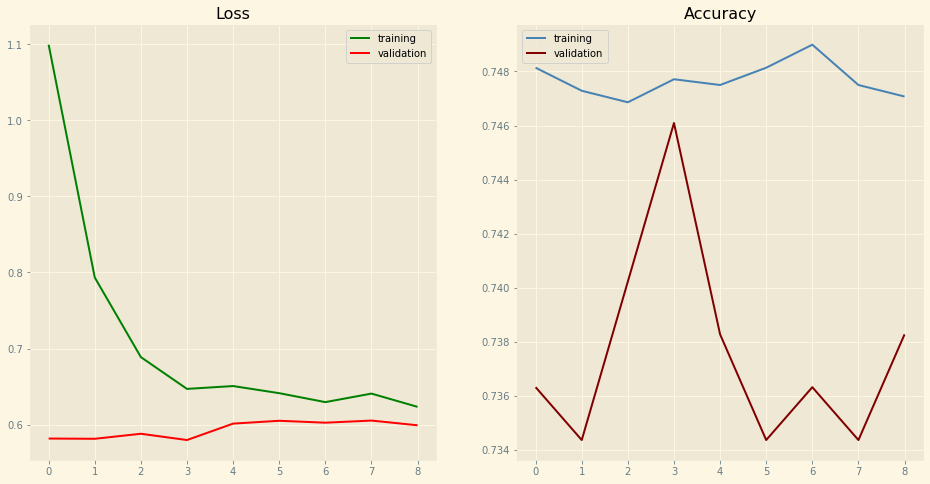

In [14]:
#model fitting:

history2=model2.fit(train,validation_data=val,epochs=epochs2,class_weight=weights,
                    steps_per_epoch=train.n//batch_size,validation_steps=val.n//batch_size,
                    callbacks=[reduce_lr,early_stopping],verbose=0)

#plotting learning curve:

plot_history(history2)